# GSQL101 - using TigerGraph Cloud and pyTigerGraph
by Yaniv Ben-Ami

## Establish a connection to a TigerGraph Cloud server

### Start a [TigerGraph server](https://www.tigergraph.com/cloud/)

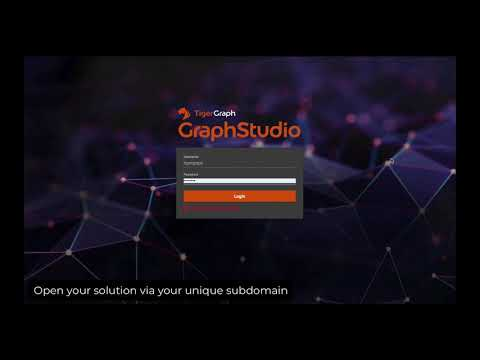

In [1]:
from IPython.display import YouTubeVideo

YouTubeVideo(width=896, height=504, id='JARd9ULRP_I')

### Install pyTigerGraph

In [2]:
!pip install pyTigerGraph

# Or when running the notebook from the pyTigerGraph repo
#!pip uninstall -y pyTigerGraph
#!pip install -e ..

Found existing installation: pyTigerGraph 0.0.6.9
Uninstalling pyTigerGraph-0.0.6.9:
  Successfully uninstalled pyTigerGraph-0.0.6.9
Obtaining file:///Users/ybenami/EasyAsPie.ai/pyTigerGraph
  Running setup.py develop for pyTigerGraph


## Enter your server's ip address and password

In [3]:
import getpass

server = 'https://yaniv.i.tgcloud.io'
password = getpass.getpass()

········


## Set up a pyTigerGraph connection to the server

In [4]:
import pyTigerGraph as tg 

conn = tg.TigerGraphConnection(
    host=server, 
    graphname='social', 
    password=password, 
    clientVersion="2.6.0")

## Test your connection

Use `options=[]` when issuing GSQL instructions to global instead of your default graph. When running `ls` in global mode you will see all the vertices and edges from all your graphs. In my case, there are currently three graphs already loaded on the server.   

In [5]:
print(conn.gsql('ls', options=[]))

Trying version: v2_6_0
Connecting to yaniv.i.tgcloud.io:14240
If there is any relative path, it is relative to tigergraph/dev/gdk/gsql
---- Global vertices, edges, and all graphs
Vertex Types: 
  - VERTEX Patient(PRIMARY_ID patient_id STRING, name STRING, gender STRING, birth DATETIME, death DATETIME) WITH STATS="OUTDEGREE_BY_EDGETYPE", PRIMARY_ID_AS_ATTRIBUTE="true"
  - VERTEX Provider(PRIMARY_ID provider_id STRING, name STRING, specialty STRING) WITH STATS="OUTDEGREE_BY_EDGETYPE", PRIMARY_ID_AS_ATTRIBUTE="true"
  - VERTEX Encounter(PRIMARY_ID encounter_id STRING, description STRING, startTime DATETIME, endTime DATETIME) WITH STATS="OUTDEGREE_BY_EDGETYPE", PRIMARY_ID_AS_ATTRIBUTE="true"
  - VERTEX Condition(PRIMARY_ID condition_id STRING, description STRING, startDate DATETIME, endDate DATETIME) WITH STATS="OUTDEGREE_BY_EDGETYPE", PRIMARY_ID_AS_ATTRIBUTE="true"
  - VERTEX Procedures(PRIMARY_ID procedure_id STRING, description STRING, startTime DATETIME, endTime DATETIME) WITH STATS="O

### Clear the server if you need to (be careful with this)

In [6]:
#print(conn.gsql('drop all', options=[]))

### To clear a particular graph drop its queries, then the graph, then its edges, then its vertices

In [7]:
print(conn.gsql('''
drop query hello
drop query hello2
drop graph social
drop edge friendship
drop vertex person
'''))

Trying version: v2_6_0
Connecting to yaniv.i.tgcloud.io:14240
If there is any relative path, it is relative to tigergraph/dev/gdk/gsql
The query hello is dropped.
The query hello2 is dropped.
The graph social is dropped.
The edge type friendship is dropped.
The vertex type person is dropped.



### Create the graph schema

See [GSQL 101 - Module 1: Graph Schema](https://youtu.be/him2Uy3Nn7Y)


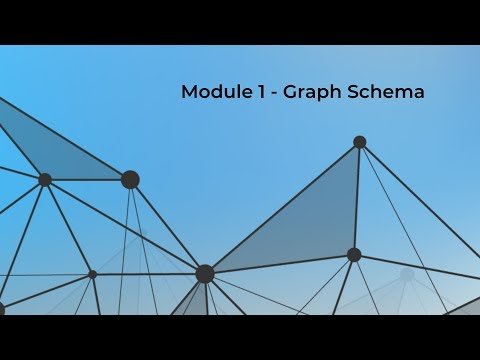

In [8]:
YouTubeVideo(width=896, height=504, id='him2Uy3Nn7Y')

In [9]:
print(conn.gsql('''
create vertex person (primary_id name string, name string, age int, 
                      gender string, state string)
                      
create undirected edge friendship (from person, to person, 
                                   connect_day datetime)

create graph social (person, friendship)
''', options=[]))

Trying version: v2_6_0
Connecting to yaniv.i.tgcloud.io:14240
If there is any relative path, it is relative to tigergraph/dev/gdk/gsql
The vertex type person is created.
The edge type friendship is created.
The graph social is created.



### Write data files to disk

In [10]:
%%writefile person.csv
name,gender,age,state
Tom,male,40,ca
Dan,male,34,ny
Jenny,female,25,tx
Kevin,male,28,az
Amily,female,22,ca
Nancy,female,20,ky
Jack,male,26,fl

Overwriting person.csv


In [11]:
%%writefile friendship.csv
person1,person2,date
Tom,Dan,2017-06-03
Tom,Jenny,2015-01-01
Dan,Jenny,2016-08-03
Jenny,Amily,2015-06-08
Dan,Nancy,2016-01-03
Nancy,Jack,2017-03-02
Dan,Kevin,2015-12-30

Overwriting friendship.csv


## Use pyTigerGraph to upsert data

If using a secure server you'll need to get a secret and a token

In [12]:
secret = conn.createSecret()
conn.getToken(secret=secret);

In [13]:
import pandas as pd

person = pd.read_csv('person.csv')
person

,name,gender,age,state
0,Tom,male,40,ca
1,Dan,male,34,ny
2,Jenny,female,25,tx
3,Kevin,male,28,az
4,Amily,female,22,ca
5,Nancy,female,20,ky
6,Jack,male,26,fl


In [14]:
conn.upsertVertexDataframe(
    df=person, vertexType='person', v_id='name')

7

In [15]:
friendship = pd.read_csv('friendship.csv')
friendship

,person1,person2,date
0,Tom,Dan,2017-06-03
1,Tom,Jenny,2015-01-01
2,Dan,Jenny,2016-08-03
3,Jenny,Amily,2015-06-08
4,Dan,Nancy,2016-01-03
5,Nancy,Jack,2017-03-02
6,Dan,Kevin,2015-12-30


In [16]:
conn.upsertEdgesDataframe(
    df=friendship, 
    sourceVertexType='person', 
    edgeType='friendship', 
    targetVertexType='person',
    from_id='person1', 
    to_id='person2', 
    attributes={'connect_day':'date'})

7

### Downloading dataframes

In [17]:
# select argument must be comma delimited with no spaces
conn.getVertexDataframe('person', select='age,gender', where='age > 22')

,v_id,age,gender
0,Dan,34,male
1,Tom,40,male
2,Jenny,25,female
3,Jack,26,male
4,Kevin,28,male


We can ask for specific vertices by providing a list of their IDs.

In [18]:
conn.getVertexDataframeByID('person', ['Tom', 'Jenny'])

,v_id,name,age,gender,state
0,Tom,Tom,40,male,ca
1,Jenny,Jenny,25,female,tx


To collect edges one must provide a list of vertices they are connected to.

In [19]:
conn.getEdgesDataframe('person', ['Tom', 'Jenny'], 'friendship')

,e_type,directed,from_id,to_id,to_type,connect_day
0,friendship,False,Tom,Jenny,person,2015-01-01 00:00:00
1,friendship,False,Tom,Dan,person,2017-06-03 00:00:00
2,friendship,False,Jenny,Amily,person,2015-06-08 00:00:00
3,friendship,False,Jenny,Tom,person,2015-01-01 00:00:00
4,friendship,False,Jenny,Dan,person,2016-08-03 00:00:00


## Built-in `SELECT` queries

See [GSQL 101 - Module 3: Graph Inspection Language](https://youtu.be/akGOSEWMC8I)

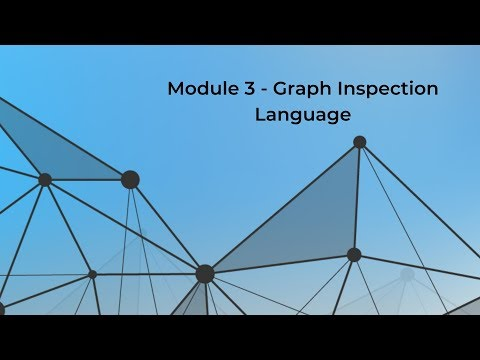

In [20]:
YouTubeVideo(width=896, height=504, id='akGOSEWMC8I')

### `SELECT` queries return a native Python structure

In [21]:
q = conn.gsql('select count(*) from person')
q

[{'count': 7, 'v_type': 'person'}]

In [22]:
q[0]['count']

7

### Since this is GSQL the `FROM` argument can be a pattern 

In [23]:
conn.gsql('select count() from person-(friendship)-person')

[{'count': 7, 'e_type': 'friendship'}]

### The `WHERE` arument is a filter on the `FROM` pattern

In [24]:
conn.gsql('select * from person where primary_id=="Tom"')

[{'v_id': 'Tom',
  'attributes': {'gender': 'male', 'name': 'Tom', 'state': 'ca', 'age': 40},
  'v_type': 'person'}]

In [25]:
q = conn.gsql('select * from person where gender=="female"')
q 

[{'v_id': 'Nancy',
  'attributes': {'gender': 'female',
   'name': 'Nancy',
   'state': 'ky',
   'age': 20},
  'v_type': 'person'},
 {'v_id': 'Jenny',
  'attributes': {'gender': 'female',
   'name': 'Jenny',
   'state': 'tx',
   'age': 25},
  'v_type': 'person'},
 {'v_id': 'Amily',
  'attributes': {'gender': 'female',
   'name': 'Amily',
   'state': 'ca',
   'age': 22},
  'v_type': 'person'}]

### Use Python's list comprehension to access results

In [26]:
[v['attributes']['age'] for v in q]

[20, 25, 22]

### Transform into a Pandas DataFrame

In [27]:
import pandas as pd

pd.DataFrame([v['attributes'] for v in q])

,gender,name,state,age
0,female,Nancy,ky,20
1,female,Jenny,tx,25
2,female,Amily,ca,22


## User defined queries

See [GSQL 101 - Module 4: Basic GSQL](https://youtu.be/eK6f7qnylj0) 

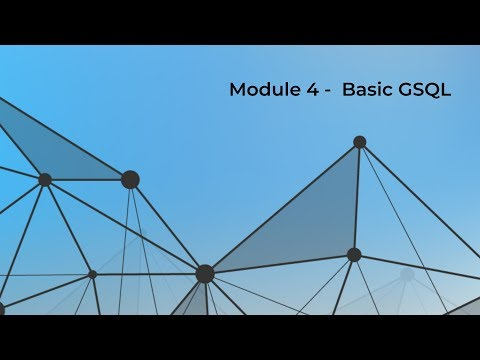

In [28]:
YouTubeVideo(width=896, height=504, id='eK6f7qnylj0')

### Queries can saved and compiled (this takes about a minute)

In [29]:
print(conn.gsql('''
drop query hello

create query hello(vertex<person> p) for graph social{
    
    start = {p};
    tgt = select t from start:s-(friendship:e)-person:t ;
    print tgt;
}

install query hello
'''))

Trying version: v2_6_0
Connecting to yaniv.i.tgcloud.io:14240
If there is any relative path, it is relative to tigergraph/dev/gdk/gsql
Query hello could not be found.
The query hello has been added!
Start installing queries, about 1 minute ...
hello query: curl -X GET 'https://127.0.0.1:9000/query/social/hello?p=VALUE'. Add -H "Authorization: Bearer TOKEN" if authentication is enabled.

[=================================================================] 100% (1/1) 



### Run the installed query and process the output

In [30]:
q = conn.gsql('run query hello({})'.format('"Tom"'))
q

{'error': False,
 'message': '',
 'version': {'schema': 21, 'edition': 'enterprise', 'api': 'v2'},
 'results': [{'tgt': [{'v_id': 'Jenny',
     'attributes': {'gender': 'female',
      'name': 'Jenny',
      'state': 'tx',
      'age': 25},
     'v_type': 'person'},
    {'v_id': 'Dan',
     'attributes': {'gender': 'male', 'name': 'Dan', 'state': 'ny', 'age': 34},
     'v_type': 'person'}]}]}

In [31]:
[v['attributes']['age'] for v in q['results'][0]['tgt']]

[25, 34]

## Accumulators

See [GSQL 101 - Module 5: Advanced GSQL (Accumulators)](https://youtu.be/ysrm9OjVoqg)

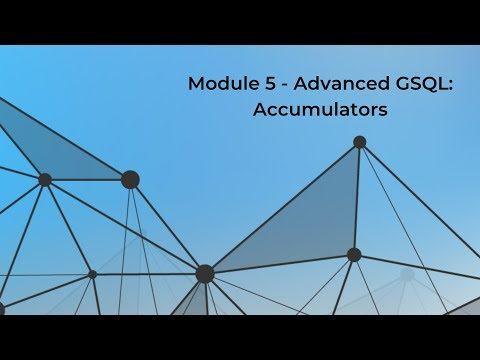

In [32]:
YouTubeVideo(width=896, height=504, id='ysrm9OjVoqg')

### Measuring hop distance

Measuring hop distance requires that we flag every vertex we visit using a local accumulator `@visited`. Note how results exclude Jenny and Dan even though they are a friend of a friend of Tom. This is because they are also direct friends of Tom.

In [33]:
print(conn.gsql('''
drop query hello2

create query hello2(vertex<person> p) for graph social {
    
    OrAccum @visited = false;
    AvgAccum @@aveAge;
    
    start = {p};
    
    firstHop = select t from start:s-(friendship:e)-person:t
               accum t.@visited += true, s.@visited += true;
    
    secondHop = select t from firstHop:s-(friendship:e)-person:t
                where t.@visited == false
                post_accum @@aveAge += t.age;
    
    print secondHop;
    print @@aveAge;
            
}

install query hello2
'''))

Trying version: v2_6_0
Connecting to yaniv.i.tgcloud.io:14240
If there is any relative path, it is relative to tigergraph/dev/gdk/gsql
Query hello2 could not be found.
The query hello2 has been added!
Start installing queries, about 1 minute ...
hello2 query: curl -X GET 'https://127.0.0.1:9000/query/social/hello2?p=VALUE'. Add -H "Authorization: Bearer TOKEN" if authentication is enabled.

[=================================================================] 100% (1/1) 



In [34]:
q = conn.gsql('run query hello2("Tom")')
q

{'error': False,
 'message': '',
 'version': {'schema': 21, 'edition': 'enterprise', 'api': 'v2'},
 'results': [{'secondHop': [{'v_id': 'Amily',
     'attributes': {'gender': 'female',
      '@visited': False,
      'name': 'Amily',
      'state': 'ca',
      'age': 22},
     'v_type': 'person'},
    {'v_id': 'Nancy',
     'attributes': {'gender': 'female',
      '@visited': False,
      'name': 'Nancy',
      'state': 'ky',
      'age': 20},
     'v_type': 'person'},
    {'v_id': 'Kevin',
     'attributes': {'gender': 'male',
      '@visited': False,
      'name': 'Kevin',
      'state': 'az',
      'age': 28},
     'v_type': 'person'}]},
  {'@@aveAge': 23.33333}]}

### Global accumulators 
We can verify that the global accumulator `@@aveAge` did its job correctly.

In [35]:
q['results'][1]['@@aveAge']

23.33333

In [36]:
ages = [v['attributes']['age'] for v in q['results'][0]['secondHop']]
ages

[22, 20, 28]

In [37]:
sum(ages)/len(ages)

23.333333333333332